# Analysis, Goals, and Predictions

Here, I'd like to go over the loss functions being used to train the models and what we are aiming for, so that we can better understand the models' performance as training progresses. My approach will follow that of Ng (2015), as outlined in the textbook __"Deep Learning" by Goodfellow et al.__:

* Determine your goals -- error metric(s) and target (re: desired) value(s). 
* Establish a working end-to-end pipeline. 
* Determine bottlenecks in performance, their sources, and whether they're due to overfitting/underfitting/software defect(s). 
* Repeatedly make incremental changes such as gathering new data, adjusting hyperparams, or changing algorithms. 

## Selecting Hyperparameters

#### Manual HyperParameter Tuning

Here are I'll just bullet the main ideas:
* The learning rate is perhaps the most important hyperparameter. The training error increases appx exponentially as the learning rate decreases below its optimal value. Above the optimal value, the training error basically shoots off to infinity (vertical wall). 
* Next, the best perfomance usually comes from a large model that is regularized well, for example, by using dropout. 
* Table showing typical hyperparameter relationships with model capacity. Remember that you can basically brute force your way to good performance by jacking up the model capacity and training set size. 

| Hyperparameter | Increases capacity when... | 
| -------------- | -------------------------- |
| Num hidden units | increased | 
| Learning rate | tuned optimally |
| Convolution kernal width | increased | 
| Implicit zero padding | increased | 
| Weight decay coefficient | decreased | 
| Dropout rate | decreased | 


#### Automatic HyperParameter Optimization

__Grid Search__: This is what I'm doing right now. User selects a small finite set of values to explore. Grid search trains a model for every joint specification of hyperparameter values in the Cartesian product of possible values. The experiment with the best _validation error_ is chosen as the best. 

__Random Search (Better)__: 
1. Define a marginal distribution for each hyperparameter, e.g. multinoulli for discrete hparams or uniform (log-scale) for positive real-valued hyparams. For example, if we were interested in the range $[10^{-5}, 0.1]$ for the learning rate:
$$
\begin{align}
\texttt{logLearningRate} &\sim Unif[-1, -5] \\
\texttt{learningRate} &= 10^{logLearningRate}
\end{align}
$$

## Debugging Strategies

Determining whether or not a machine learning model is broken is hard. Here are some debugging tips:
* __Visualize the model in action__: Not just the quantitative stuff. How do the filters look? How is the chatbot responding?
* __Visualize the worst mistakes__: For example, our chatbot models output probabilities for the word tokens, and we either sample or argmax. One way to get an idea of what sentences our model does poorly on is to choose examples where the output probability max is *small*. In other words, if argmax(output) is much lower than usual, that says our model is rather unsure what is the best next word (think of the limiting case where it outputs 1/numOutputs for all possible tokens!). 
* __Fit a tiny dataset__: Oooh, I like this one! Even small models can be guaranteed to be able to fit a sufficiently small dataset. Make sure you can write program that can train on say, a handful of input-output sentences, and produce the output given any of the inputs with near perfect accuracy. 
* __Monitor histograms of activations/gradients__: The preactivation can tell us if the units saturate, or how often they do. For tanh units, the average of the absolute value of the preactivations tells us how saturated the unit is. It is also useful to compare the parameter gradients with the parameters themselves. Ideally, we'd like the gradients over a minibatch to be about 1 percent of the magnitude of the parameter. 

## Plotting the Search Results

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 8


path = '/home/brandon/Documents/seq2seq_projects/data/saved_train_data/cornell.csv'
df = pd.read_csv(path, index_col=0)
df.head()

,embed_size,global_step,learning_rate,loss,state_size,vocab_size
0,56,2,0.189885,9.211146,380,10000
0,56,203,0.189885,5.385020,380,10000
0,56,404,0.189885,5.219425,380,10000
0,56,605,0.189885,4.849638,380,10000
0,56,806,0.189885,4.682628,380,10000


In [44]:
embed_sizes = set(df['embed_size'])
state_sizes = set(df['state_size'])
learning_rates = set(df['learning_rate'])
print(embed_sizes)
print(state_sizes)
print(learning_rates)

{56, 33, 32, 64, 30}
{256, 128, 512, 240, 244, 344, 380}
{0.18988533360611451, 0.20000000000000001, 0.059999999999999998, 0.41678070562735708, 0.69999999999999996, 0.02303983315704328}


#### Single Plots Distinguishing One Variable

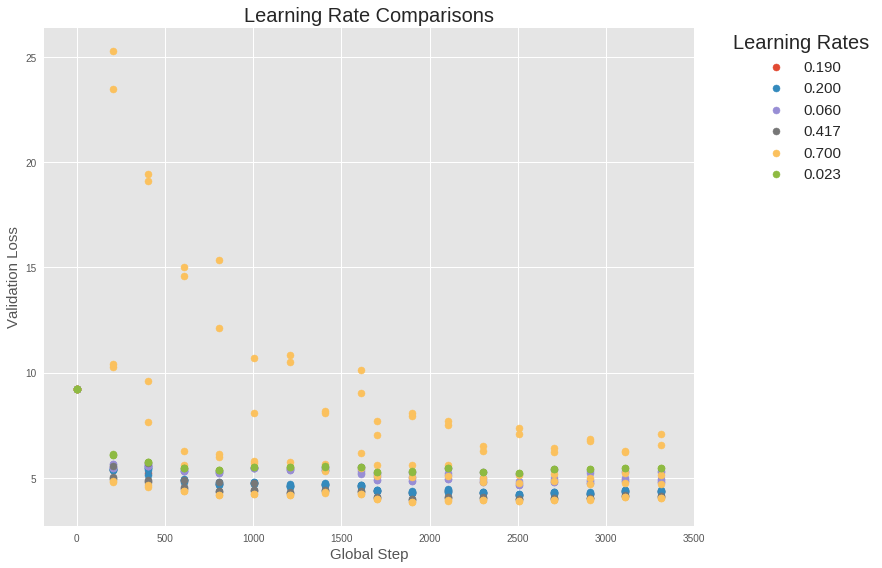

In [86]:
df_by_lr = [(lr, df[df['learning_rate']==lr]) for lr in learning_rates]

plt.figure(figsize=(10, 8))
for lr, df_lr in df_by_lr:
    ax=plt.subplot()
    plt.scatter(df_lr['global_step'], df_lr['loss'], label='%.3f' % lr)
    
plt.title('Learning Rate Comparisons', fontsize=20)
ax.set_xlabel('Global Step', fontsize=15)
ax.set_ylabel('Validation Loss', fontsize=15)
leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           title='Learning Rates', prop={'size':15})
plt.setp(leg.get_title(),fontsize=20)
plt.tight_layout()
plt.savefig('lr_compare.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

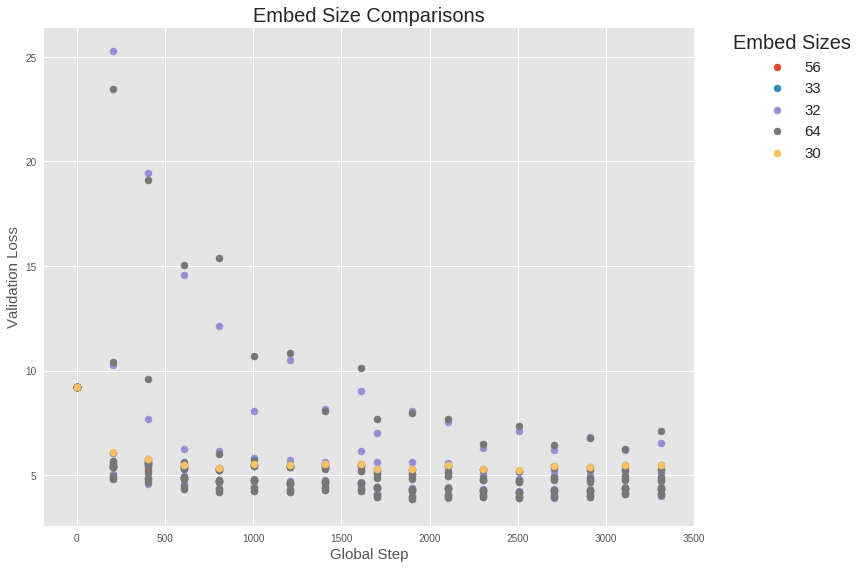

In [84]:
df_by_embed = [(em, df[df['embed_size']==em]) for em in embed_sizes]

plt.figure(figsize=(10, 8))
for em, df_em in df_by_embed:
    ax=plt.subplot()
    plt.scatter(df_em['global_step'], df_em['loss'], label=em)

plt.title('Embed Size Comparisons', fontsize=20)
ax.set_xlabel('Global Step', fontsize=15)
ax.set_ylabel('Validation Loss', fontsize=15)
leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           title='Embed Sizes', prop={'size':15})
plt.setp(leg.get_title(),fontsize=20)
plt.tight_layout()
plt.savefig('em_compare.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

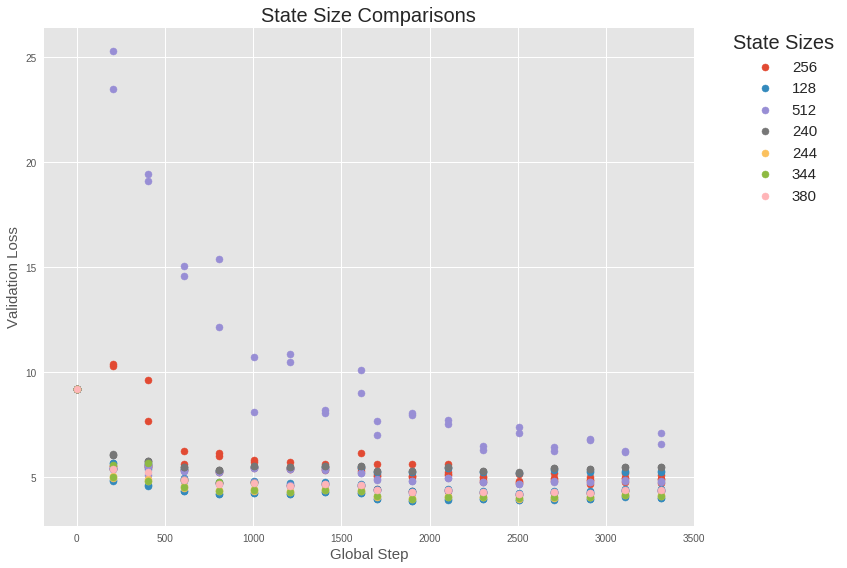

In [83]:
df_by_state = [(st, df[df['state_size']==st]) for st in state_sizes]

plt.figure(figsize=(10, 8))
for st, df_st in df_by_state:
    ax=plt.subplot()
    plt.scatter(df_st['global_step'], df_st['loss'], label=st)
    
plt.title('State Size Comparisons', fontsize=20)
ax.set_xlabel('Global Step', fontsize=15)
ax.set_ylabel('Validation Loss', fontsize=15)
leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           title='State Sizes', prop={'size':15})
plt.setp(leg.get_title(),fontsize=20)
plt.tight_layout()
plt.savefig('st_compare.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

#### Plots with Fixed Learning Rate

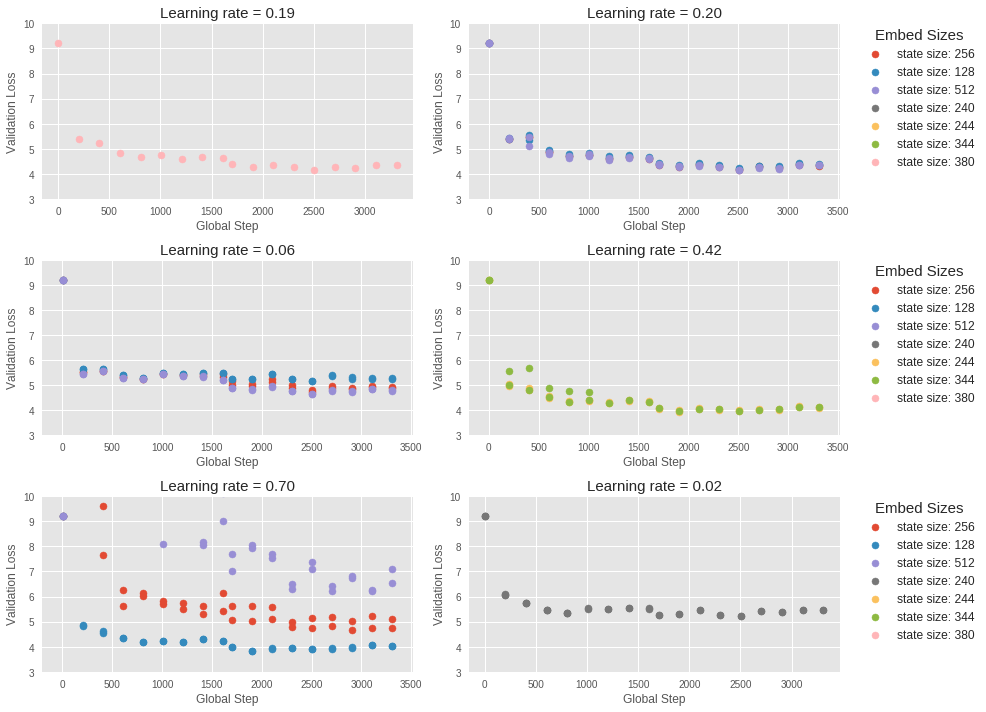

In [82]:
df_max_lr = df[df['learning_rate']==0.7]
df_max_lr_by_state_size = [(s, df_max_lr[df_max_lr['state_size']==s]) for s in state_sizes]

fig = plt.figure(figsize=(12, 10))
ctr = 1
for lr, df_lr in df_by_lr:
    df_by_state_size = [(s, df_lr[df_lr['state_size']==s]) for s in state_sizes]
    ax=fig.add_subplot(3, 2, ctr)
    for s, df_state in df_by_state_size:
        ax.scatter(df_state['global_step'], df_state['loss'], label='state size: %d' % s)
        ax.set_ylim([3., 10.])
        
        plt.title('Learning rate = %.2f' % lr, fontsize=15)
        ax.set_xlabel('Global Step', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        if ctr in [2, 4, 6]:
            leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                   title='Embed Sizes', prop={'size':12})
            plt.setp(leg.get_title(),fontsize=15)
    ctr += 1
plt.tight_layout()
plt.savefig('fix_lr_subs.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()